In [55]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import numpy as np

<p style="border:3px #ff0000  solid;">
Задача: по замерам акселерометра и гироскопа, произведенным с помощью телефона, находящегося на поясе, научиться отделять различные типы активностей друг от друга.

<p style="border:3px #ff0000  solid;">
1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.

In [56]:
activ_NDArr = np.loadtxt('C:/Users/Z/PycharmProjects/data_science_1t/task_2.5/X_train.txt')
activ_df = pd.DataFrame(activ_NDArr)

<p style="border:3px #ff0000  solid;">
2. Ознакомьтесь с данными:

     а) выведите количество признаков;

In [57]:
activ_df.shape

(7352, 561)

    b) есть ли в данных пропуски;

In [58]:
propuski = 0
for i in activ_df.isna().sum():
    if i > 0:
        print('Есть пропуски')
        print(i)
        propuski += 1
if propuski == 0:
    print('Пропусков нет')

Пропусков нет


    c) отличаются ли различные признаки по масштабу.

In [59]:
activ_df.mean().mean()

-0.5083650377341115

In [60]:
activ_df.median().median()

-0.916926385

<p style="border:3px #00B344  solid;">
Всего в данных содержится 561 признак. Пропусков в данных нет. Данные имеют примерно одинаковый масштаб.
</p>

<p style="border:3px #ff0000  solid;">
3. Понизьте размерность данных:

     a) воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

In [61]:
varianceThreshold = VarianceThreshold(threshold=0.01)
activ_df = varianceThreshold.fit_transform(activ_df)
activ_df.shape

(7352, 524)

     b) воспользуйтесь методом PCA:

          приведите признаки к одинаковому масштабу,
          визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


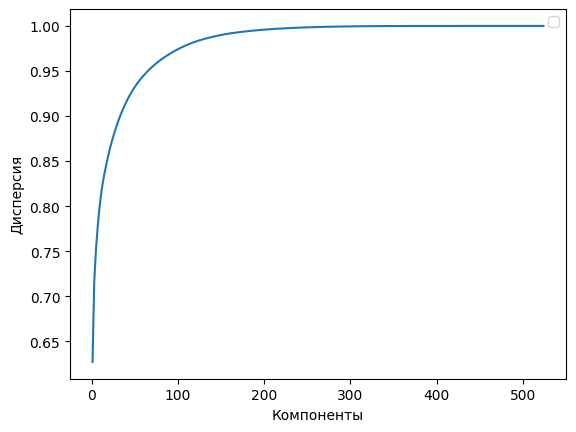

In [62]:
pca = PCA()

pca_df = pca.fit_transform(activ_df)

var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
plt.plot(range(1, len(var_exp) + 1), cum_var_exp)
plt.ylabel('Дисперсия')
plt.xlabel('Компоненты')
plt.legend(loc='best')
plt.show()

<p style="border:3px #00B344  solid;">
Данные имеют примерно одинаковый масштаб. Масштабирование не требуется.
</p>

     определите минимальное необходимое количество главных компонент,  при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

In [63]:
min_components = np.argmax(cum_var_exp >= 0.9) + 1
print("Минимальное количество компонентов для дисперсии больше 0.9: ", min_components)

Минимальное количество компонентов для дисперсии больше 0.9:  33


     выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

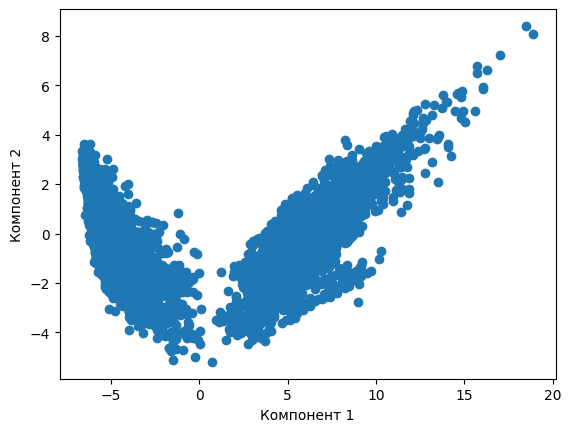

In [64]:
pca_2 = PCA(n_components = 2)
pca_df_2 = pca_2.fit_transform(activ_df)

plt.scatter(pca_df_2[:, 0], pca_df_2[:, 1])
plt.xlabel("Компонент 1")
plt.ylabel("Компонент 2")
plt.show()

<p style="border:3px #ff0000  solid;">
4. Подберите оптимальное число кластеров: 

    a) воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

In [65]:
distortion = []
K = range(1, 10)
for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=4)
    model.fit(activ_df)
    distortion.append(model.inertia_)

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Z\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [00:00<00:03,  2.55it/s]c:\Users\Z\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 22%|██▏       | 2/9 [00:00<00:02,  2.39it/s]c:\Users\Z\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_v

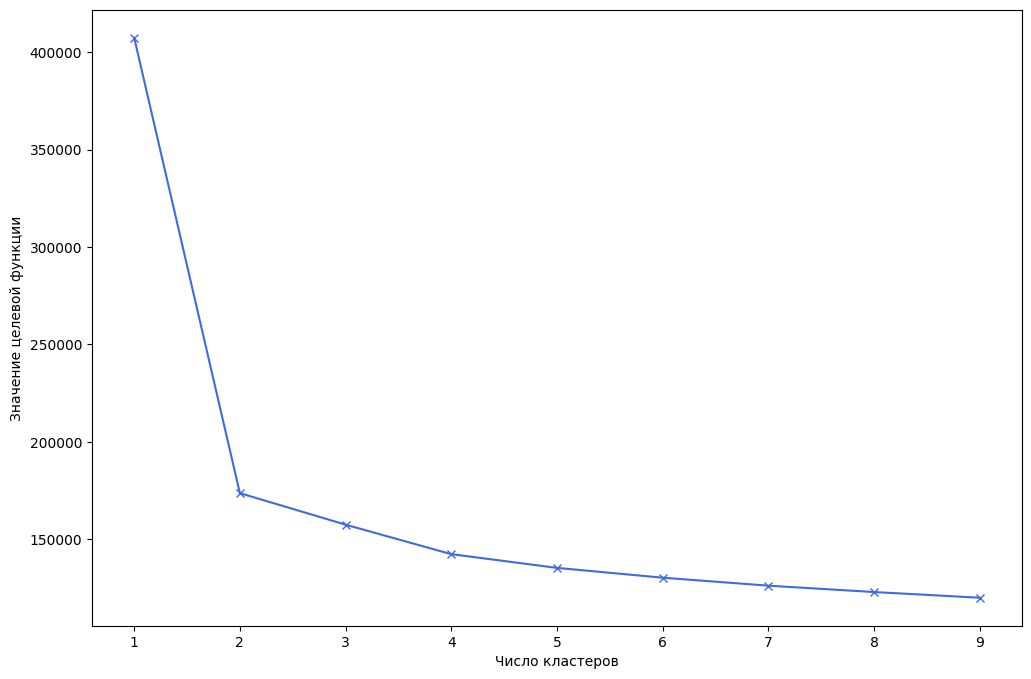

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, c='royalblue', marker='x')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

    b) выберите оптимальное количество кластеров и объясните свой выбор;

<p style="border:3px #00B344  solid;">
Из представленного графика видно, что оптимальное количество кластеров равно 2, так как график выходит на плато и при дальнейшем увеличении кластеров значительного изменения значения целевой функции не происходит.</p>

    c) повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

c:\Users\Z\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


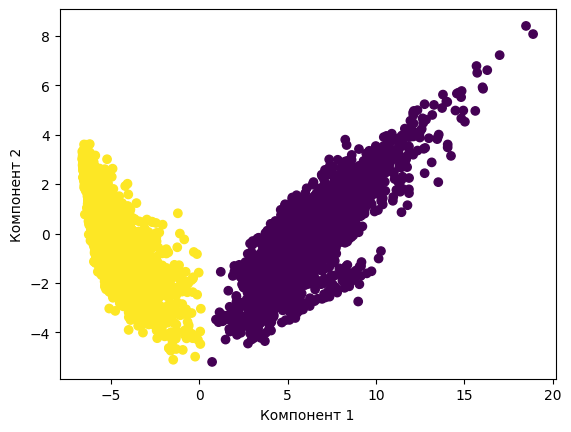

In [67]:
model_2_clust = KMeans(n_clusters=2, random_state=4)
model_2_clust.fit(pca_df_2)

map_color = {0: 'lightblue', 1: 'darkgreen'}
plt.scatter(pca_df_2[:, 0], pca_df_2[:, 1], c=model_2_clust.labels_)
plt.xlabel("Компонент 1")
plt.ylabel("Компонент 2")
plt.show()

<p style="border:3px #ff0000  solid;">
5. Оцените качество кластеризации:

    a) подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

In [68]:
y_train = np.loadtxt('y_train.txt')
y_train_df = pd.DataFrame(y_train, columns=['activity'])
activ_rus = {1.0: 'ходьба', 2.0 : 'ходьба на подъем', 3.0 : 'ходьба на спуск', 4.0 : 'сидение', 5.0 : 'положение стоя', 6.0 : 'положение лежа'}
y_train_df.activity = y_train_df.activity.replace(activ_rus)
y_train_df

,activity
0,положение стоя
1,положение стоя
2,положение стоя
3,положение стоя
4,положение стоя
...,...
7347,ходьба на подъем
7348,ходьба на подъем
7349,ходьба на подъем
7350,ходьба на подъем


In [69]:
activity_labels = pd.read_csv('activity_labels.txt', names=['activity'])
activity_labels

,activity
0,1 WALKING
1,2 WALKING_UPSTAIRS
2,3 WALKING_DOWNSTAIRS
3,4 SITTING
4,5 STANDING
5,6 LAYING


    b) определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

In [70]:
labels_df = pd.DataFrame({'cluster' : model_2_clust.labels_, 'activity': y_train_df['activity']})
activity_cluster = pd.pivot_table(labels_df, index='activity', columns='cluster', aggfunc=len, fill_value=0)
activity_cluster

cluster,0,1
activity,,
положение лежа,11,1396
положение стоя,0,1374
сидение,1,1285
ходьба,1226,0
ходьба на подъем,1073,0
ходьба на спуск,986,0


    c) сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.

<p style="border:3px #00B344  solid;">
Полученная кластеризация вполне логична, так как положение лежа, положение стоя и сидение отнесены к одному кластеру - пассивной деятельности, а остальные во второй кластер - активной деятельности.</p>